- BatchNormalization
- Resnet, Senet
- Hyperparameter Tuning
- retrain different layers
- mixed precision tests

In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.keras.__version__)
print(tf.__version__)
tf.config.list_physical_devices('GPU')
#keras.mixed_precision.set_global_policy("mixed_float16") # turn on mixed precision for faster computation

2.12.0
2.12.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/train_set'
test_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/val_set'
#train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted_balanced_small/train_set'
#test_img_dir = '/home/lndr/Development/FER/AffectNet_sorted_balanced_small/val_set'

In [3]:
import random

def load_data(train_img_dir, test_img_dir, image_size=(224,224), batch_size=32, validation_split=0.2):

    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_img_dir,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True,
        seed=random.randint(0,1000),
        validation_split=validation_split,
        subset='both'
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_img_dir,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True,
        seed=random.randint(0,1000),
        validation_split=None
    )

    return train_dataset, test_dataset

In [15]:
import matplotlib.pyplot as plt

def plot_history(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

In [4]:
import numpy as np

classes = {0: 'neutral', 
           1: 'happiness', 
           2: 'sadness', 
           3: 'surprise', 
           4: 'fear', 
           5: 'disgust', 
           6: 'anger', 
           7: 'contempt'}

# calculate weights on class distribution from 0-7
total_images = 287_652
images_per_class = [74_874, 134_415, 25_459, 14_090, 6_378, 3_803, 24_882, 3_750]
class_distribution = [d/total_images for d in images_per_class]
# inverse class distribution for weights (lower dist = higher weight)
class_weights = [1.0 / dist for dist in class_distribution]
# normalize
class_weights_normalized = class_weights / np.sum(class_weights)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_normalized)}
class_weights_dict

{0: 0.01557266066902349,
 1: 0.008674533310511956,
 2: 0.045798632897304084,
 3: 0.08275283143594497,
 4: 0.18281395342308948,
 5: 0.3065967380837404,
 6: 0.04686067819839501,
 7: 0.31092997198199057}

---

In [4]:
from tensorflow.keras import layers
from keras_vggface.vggface import VGGFace

# Define Data Augmentation Layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        #layers.RandomZoom(0.2),
    ]
)

# Load Base Model
vgg_model = VGGFace(model="resnet50", include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = True
for layer in vgg_model.layers[:-33]:
    layer.trainable = False
    
# Add Head Model (Finetune)
inputs = keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(inputs)
x = vgg_model(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(512, activation="relu")(x)
#x = layers.Dropout(0.5)(x)
outputs = layers.Dense(8, activation='softmax', name='classifier', dtype="float32")(x) # opt-out mixed precision for softmax layer
model = keras.Model(inputs, outputs)


vgg_model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Load dataset
(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

from datetime import datetime
now = datetime.today()
current_time = now.strftime("%Y%m%d_%H-%M")
model_name = f"{current_time}_fer_finetuning_vggFace.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=10)
]

# fit model
print(f'Saving model as: {model_name}')
history = model.fit(x=train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks)

Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                  

                                                                                                  
 conv2_3_1x1_increase (Conv2D)  (None, 55, 55, 256)  16384       ['activation_57[0][0]']          
                                                                                                  
 conv2_3_1x1_increase/bn (Batch  (None, 55, 55, 256)  1024       ['conv2_3_1x1_increase[0][0]']   
 Normalization)                                                                                   
                                                                                                  
 add_18 (Add)                   (None, 55, 55, 256)  0           ['conv2_3_1x1_increase/bn[0][0]',
                                                                  'activation_55[0][0]']          
                                                                                                  
 activation_58 (Activation)     (None, 55, 55, 256)  0           ['add_18[0][0]']                 
          

 add_21 (Add)                   (None, 28, 28, 512)  0           ['conv3_3_1x1_increase/bn[0][0]',
                                                                  'activation_64[0][0]']          
                                                                                                  
 activation_67 (Activation)     (None, 28, 28, 512)  0           ['add_21[0][0]']                 
                                                                                                  
 conv3_4_1x1_reduce (Conv2D)    (None, 28, 28, 128)  65536       ['activation_67[0][0]']          
                                                                                                  
 conv3_4_1x1_reduce/bn (BatchNo  (None, 28, 28, 128)  512        ['conv3_4_1x1_reduce[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activatio

                                                                                                  
 activation_76 (Activation)     (None, 14, 14, 1024  0           ['add_24[0][0]']                 
                                )                                                                 
                                                                                                  
 conv4_3_1x1_reduce (Conv2D)    (None, 14, 14, 256)  262144      ['activation_76[0][0]']          
                                                                                                  
 conv4_3_1x1_reduce/bn (BatchNo  (None, 14, 14, 256)  1024       ['conv4_3_1x1_reduce[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation_77 (Activation)     (None, 14, 14, 256)  0           ['conv4_3_1x1_reduce/bn[0][0]']  
          

                                                                                                  
 conv4_6_1x1_reduce/bn (BatchNo  (None, 14, 14, 256)  1024       ['conv4_6_1x1_reduce[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation_86 (Activation)     (None, 14, 14, 256)  0           ['conv4_6_1x1_reduce/bn[0][0]']  
                                                                                                  
 conv4_6_3x3 (Conv2D)           (None, 14, 14, 256)  589824      ['activation_86[0][0]']          
                                                                                                  
 conv4_6_3x3/bn (BatchNormaliza  (None, 14, 14, 256)  1024       ['conv4_6_3x3[0][0]']            
 tion)                                                                                            
          

 activation_95 (Activation)     (None, 7, 7, 512)    0           ['conv5_3_1x1_reduce/bn[0][0]']  
                                                                                                  
 conv5_3_3x3 (Conv2D)           (None, 7, 7, 512)    2359296     ['activation_95[0][0]']          
                                                                                                  
 conv5_3_3x3/bn (BatchNormaliza  (None, 7, 7, 512)   2048        ['conv5_3_3x3[0][0]']            
 tion)                                                                                            
                                                                                                  
 activation_96 (Activation)     (None, 7, 7, 512)    0           ['conv5_3_3x3/bn[0][0]']         
                                                                                                  
 conv5_3_1x1_increase (Conv2D)  (None, 7, 7, 2048)   1048576     ['activation_96[0][0]']          
          

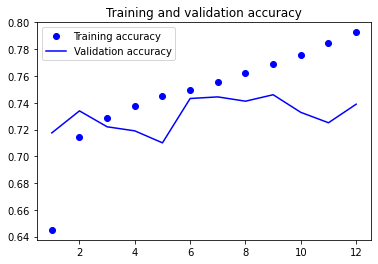

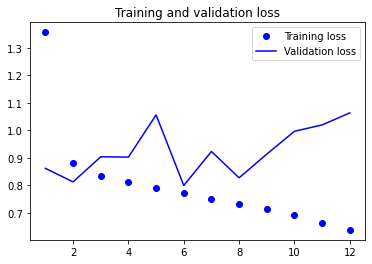

In [19]:
# complete dataset
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [9]:
# complete dataset
# adam, 1e-3, :-33 layer, epoch 2/50, no-dropout, no weighted classes
model = keras.models.load_model(model_name)
print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230712_18-15_fer_finetuning_vggFace.keras
125/125 [==============================] - 6s 46ms/step - loss: 1.6278 - accuracy: 0.4681
Test accuracy: 0.468


---

In [19]:
from tensorflow.keras import layers
from keras_vggface.vggface import VGGFace

# Define Data Augmentation Layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        #layers.RandomZoom(0.2),
    ]
)

# Load Base Model
vgg_model = VGGFace(model="resnet50", include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = True
for layer in vgg_model.layers[:-33]: # starting with res5
    layer.trainable = False
    
# Add Head Model (Finetune)
inputs = keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(inputs)
x = vgg_model(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(512, activation="relu")(x)
#x = layers.Dropout(0.5)(x)
outputs = layers.Dense(8, activation='softmax', name='classifier', dtype="float32")(x) # opt-out mixed precision for softmax layer
model = keras.Model(inputs, outputs)


#vgg_model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Load dataset
(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

from datetime import datetime
now = datetime.today()
current_time = now.strftime("%Y%m%d_%H-%M")
model_name = f"{current_time}_fer_finetuning_vggFace.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=10)
]

# fit model
print(f'Saving model as: {model_name}')
history = model.fit(x=train_dataset, 
                    epochs=50, 
                    validation_data=val_dataset,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
Saving model as: 20230712_20-31_fer_finetuning_vggFace.keras
Epoch 1/50
7192/7192 [==============================] - 481s 66ms/step - loss: 0.0411 - accuracy: 0.5624 - val_loss: 1.0302 - val_accuracy: 0.6026
Epoch 2/50
7192/7192 [==============================] - 471s 65ms/step - loss: 0.0357 - accuracy: 0.5983 - val_loss: 0.9583 - val_accuracy: 0.6285
Epoch 3/50
7192/7192 [==============================] - 472s 66ms/step - loss: 0.0319 - accuracy: 0.6234 - val_loss: 0.9578 - val_accuracy: 0.6383
Epoch 4/50
7192/7192 [==============================] - 475s 66ms/step - loss: 0.0276 - accuracy: 0.6492 - val_loss: 0.9147 - val_accuracy: 0.6543
Epoch 5/50
7192/7192 [==============================] - 479s 67ms/step - loss: 0.0228 - accuracy: 0.6835 - val_loss: 0.9277 - val_accuracy: 0.6633
Epoch 6/50
7192/7192 [==============================]

- again with monitoring and saving val_accuracy!

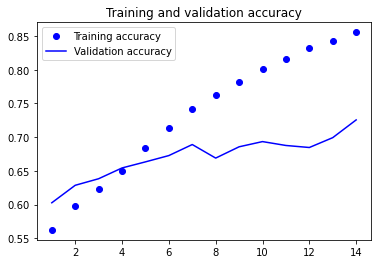

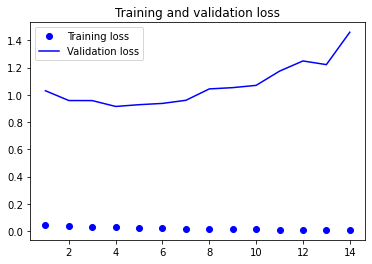

In [20]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## #3 Best Model so far:

In [6]:
# complete dataset
# adam, 1e-3, :-33 layer, epoch 4/50, no-dropout, w class weights
model = keras.models.load_model('20230712_20-31_fer_finetuning_vggFace.keras')
print(f"Evaluating: 20230712_20-31_fer_finetuning_vggFace.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230712_20-31_fer_finetuning_vggFace.keras
125/125 [==============================] - 7s 47ms/step - loss: 1.3131 - accuracy: 0.5686
Test accuracy: 0.569


---

In [7]:
from tensorflow.keras import layers
from keras_vggface.vggface import VGGFace

# Define Data Augmentation Layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        #layers.RandomZoom(0.2),
    ]
)

# Load Base Model
vgg_model = VGGFace(model="resnet50", include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = True
for layer in vgg_model.layers[:-33]:
    layer.trainable = False
    
# Add Head Model (Finetune)
inputs = keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(inputs)
x = vgg_model(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(8, activation='softmax', name='classifier', dtype="float32")(x) # opt-out mixed precision for softmax layer
model = keras.Model(inputs, outputs)


#vgg_model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Load dataset
(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

from datetime import datetime
now = datetime.today()
current_time = now.strftime("%Y%m%d_%H-%M")
model_name = f"{current_time}_fer_finetuning_vggFace.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=10)
]

# fit model
print(f'Saving model as: {model_name}')
history = model.fit(x=train_dataset, 
                    epochs=50, 
                    validation_data=val_dataset,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
Saving model as: 20230712_22-36_fer_finetuning_vggFace.keras
Epoch 1/50
7192/7192 [==============================] - 482s 66ms/step - loss: 0.0435 - accuracy: 0.5462 - val_loss: 0.9276 - val_accuracy: 0.6847
Epoch 2/50
7192/7192 [==============================] - 473s 66ms/step - loss: 0.0374 - accuracy: 0.5847 - val_loss: 1.0290 - val_accuracy: 0.6194
Epoch 3/50
7192/7192 [==============================] - 475s 66ms/step - loss: 0.0342 - accuracy: 0.5988 - val_loss: 19.1388 - val_accuracy: 0.4681
Epoch 4/50
7192/7192 [==============================] - 475s 66ms/step - loss: 0.0307 - accuracy: 0.6185 - val_loss: 1.6559 - val_accuracy: 0.3948
Epoch 5/50
7192/7192 [==============================] - 498s 69ms/step - loss: 0.0272 - accuracy: 0.6404 - val_loss: 0.9573 - val_accuracy: 0.7323
Epoch 6/50
7192/7192 [==============================

In [9]:
# complete dataset
# adam, 1e-3, :-33 layer, epoch 4/50, dropout 0.5, w class weights
model = keras.models.load_model(model_name)
print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230712_22-36_fer_finetuning_vggFace.keras
125/125 [==============================] - 5s 40ms/step - loss: 1.5840 - accuracy: 0.4449
Test accuracy: 0.445


---

In [5]:
from tensorflow.keras import layers
from keras_vggface.vggface import VGGFace

# Define Data Augmentation Layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        #layers.RandomZoom(0.2),
    ]
)

# Load Base Model
vgg_model = VGGFace(model="resnet50", include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = True
for layer in vgg_model.layers[:-21]: # one building block of res5 less
    layer.trainable = False
    
# Add Head Model (Finetune)
inputs = keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(inputs)
x = vgg_model(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(512, activation="relu")(x)
#x = layers.Dropout(0.5)(x)
outputs = layers.Dense(8, activation='softmax', name='classifier', dtype="float32")(x) # opt-out mixed precision for softmax layer
model = keras.Model(inputs, outputs)


#vgg_model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Load dataset
(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

from datetime import datetime
now = datetime.today()
current_time = now.strftime("%Y%m%d_%H-%M")
model_name = f"{current_time}_fer_finetuning_vggFace.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=10)
]

# fit model
print(f'Saving model as: {model_name}')
history = model.fit(x=train_dataset, 
                    epochs=50, 
                    validation_data=val_dataset,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
Saving model as: 20230713_06-55_fer_finetuning_vggFace.keras
Epoch 1/50
7192/7192 [==============================] - 440s 60ms/step - loss: 0.0451 - accuracy: 0.5333 - val_loss: 1.3995 - val_accuracy: 0.4276
Epoch 2/50
7192/7192 [==============================] - 432s 60ms/step - loss: 0.0397 - accuracy: 0.5683 - val_loss: 1.3393 - val_accuracy: 0.4735
Epoch 3/50
7192/7192 [==============================] - 432s 60ms/step - loss: 0.0363 - accuracy: 0.5864 - val_loss: 1.2089 - val_accuracy: 0.5361
Epoch 4/50
7192/7192 [==============================] - 434s 60ms/step - loss: 0.0329 - accuracy: 0.6048 - val_loss: 1.1663 - val_accuracy: 0.5629
Epoch 5/50
7192/7192 [==============================] - 431s 60ms/step - loss: 0.0294 - accuracy: 0.6270 - val_loss: 1.0822 - val_accuracy: 0.6144
Epoch 6/50
7192/7192 [==============================]

KeyboardInterrupt: 

- use different metric for monitoring: loss might be misleading, accuracy is better on balanced sets
- make use of f1 score, precision, recall

In [6]:
model = keras.models.load_model(model_name)
print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230713_06-55_fer_finetuning_vggFace.keras
125/125 [==============================] - 6s 47ms/step - loss: 1.8991 - accuracy: 0.5094
Test accuracy: 0.509


---

In [7]:
from tensorflow.keras import layers
from keras_vggface.vggface import VGGFace

# Define Data Augmentation Layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        #layers.RandomZoom(0.2),
    ]
)

# Load Base Model
vgg_model = VGGFace(model="resnet50", include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = True
for layer in vgg_model.layers[:-11]: # one building block of res5 less
    layer.trainable = False
    
# Add Head Model (Finetune)
inputs = keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(inputs)
x = vgg_model(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(512, activation="relu")(x)
#x = layers.Dropout(0.5)(x)
outputs = layers.Dense(8, activation='softmax', name='classifier', dtype="float32")(x) # opt-out mixed precision for softmax layer
model = keras.Model(inputs, outputs)


#vgg_model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Load dataset
(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

from datetime import datetime
now = datetime.today()
current_time = now.strftime("%Y%m%d_%H-%M")
model_name = f"{current_time}_fer_finetuning_vggFace.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=10)
]

# fit model
print(f'Saving model as: {model_name}')
history = model.fit(x=train_dataset, 
                    epochs=50, 
                    validation_data=val_dataset,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
Saving model as: 20230713_08-42_fer_finetuning_vggFace.keras
Epoch 1/50
7192/7192 [==============================] - 402s 56ms/step - loss: 0.0475 - accuracy: 0.5196 - val_loss: 1.1319 - val_accuracy: 0.5733
Epoch 2/50
7192/7192 [==============================] - 407s 57ms/step - loss: 0.0423 - accuracy: 0.5543 - val_loss: 1.2488 - val_accuracy: 0.5245
Epoch 3/50
7192/7192 [==============================] - 402s 56ms/step - loss: 0.0398 - accuracy: 0.5661 - val_loss: 1.1029 - val_accuracy: 0.5850
Epoch 4/50
7192/7192 [==============================] - 412s 57ms/step - loss: 0.0373 - accuracy: 0.5764 - val_loss: 1.0890 - val_accuracy: 0.5941
Epoch 5/50
7192/7192 [==============================] - 410s 57ms/step - loss: 0.0352 - accuracy: 0.5847 - val_loss: 1.0233 - val_accuracy: 0.6275
Epoch 6/50
7192/7192 [==============================]

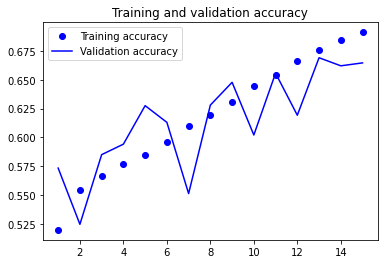

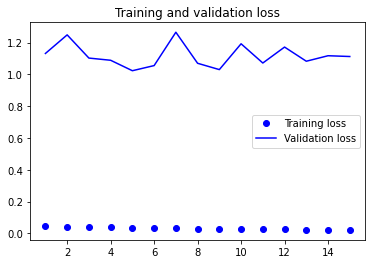

In [8]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [9]:
model = keras.models.load_model(model_name)
print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230713_08-42_fer_finetuning_vggFace.keras
125/125 [==============================] - 6s 41ms/step - loss: 1.6153 - accuracy: 0.5006
Test accuracy: 0.501


---

In [10]:
from tensorflow.keras import layers
from keras_vggface.vggface import VGGFace

# Define Data Augmentation Layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        #layers.RandomZoom(0.2),
    ]
)

# Load Base Model
vgg_model = VGGFace(model="resnet50", include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = True
for layer in vgg_model.layers[:-33]: # starting with res5
    layer.trainable = False
    
# Add Head Model (Finetune)
inputs = keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(inputs)
x = vgg_model(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(1024, activation="relu")(x)
#x = layers.Dropout(0.5)(x)
outputs = layers.Dense(8, activation='softmax', name='classifier', dtype="float32")(x) # opt-out mixed precision for softmax layer
model = keras.Model(inputs, outputs)


#vgg_model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Load dataset
(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

from datetime import datetime
now = datetime.today()
current_time = now.strftime("%Y%m%d_%H-%M")
model_name = f"{current_time}_fer_finetuning_vggFace.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=5)
]

# fit model
print(f'Saving model as: {model_name}')
history = model.fit(x=train_dataset, 
                    epochs=50, 
                    validation_data=val_dataset,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
Saving model as: 20230713_10-28_fer_finetuning_vggFace.keras
Epoch 1/50
7192/7192 [==============================] - 488s 67ms/step - loss: 0.0415 - accuracy: 0.5590 - val_loss: 0.9665 - val_accuracy: 0.6348
Epoch 2/50
7192/7192 [==============================] - 487s 68ms/step - loss: 0.0357 - accuracy: 0.5996 - val_loss: 0.9534 - val_accuracy: 0.6336
Epoch 3/50
7192/7192 [==============================] - 493s 69ms/step - loss: 0.0319 - accuracy: 0.6207 - val_loss: 0.9009 - val_accuracy: 0.6506
Epoch 4/50
7192/7192 [==============================] - 480s 67ms/step - loss: 0.0274 - accuracy: 0.6478 - val_loss: 0.9661 - val_accuracy: 0.6297
Epoch 5/50
7192/7192 [==============================] - 497s 69ms/step - loss: 0.0230 - accuracy: 0.6798 - val_loss: 0.9140 - val_accuracy: 0.6793
Epoch 6/50
7192/7192 [==============================]

## #2 Best Model so far:

In [11]:
model = keras.models.load_model(model_name)
print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230713_10-28_fer_finetuning_vggFace.keras
125/125 [==============================] - 6s 43ms/step - loss: 1.2548 - accuracy: 0.5731
Test accuracy: 0.573


In [14]:
model = history.model
print(f"Evaluating: {model_name} Epoch 8/50: val_loss: 1.0160 - val_accuracy: 0.6979")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230713_10-28_fer_finetuning_vggFace.keras Epoch 8/50: val_loss: 1.0160 - val_accuracy: 0.6979
125/125 [==============================] - 5s 41ms/step - loss: 2.7563 - accuracy: 0.5266
Test accuracy: 0.527


---

In [16]:
from tensorflow.keras import layers
from keras_vggface.vggface import VGGFace

# Define Data Augmentation Layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        #layers.RandomZoom(0.2),
    ]
)

# Load Base Model
vgg_model = VGGFace(model="resnet50", include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = True
for layer in vgg_model.layers[:-33]: # starting with res5
    layer.trainable = False
    
# Add Head Model (Finetune)
inputs = keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(inputs)
x = vgg_model(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(2048Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
Saving model as: 20230713_17-30_fer_finetuning_vggFace.keras
Epoch 1/50
7192/7192 [==============================] - 476s 66ms/step - loss: 0.0418 - accuracy: 0., activation="relu")(x)
#x = layers.Dropout(0.5)(x)
outputs = layers.Dense(8, activation='softmax', name='classifier', dtype="float32")(x) # opt-out mixed precision for softmax layer
model = keras.Model(inputs, outputs)


#vgg_model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Load dataset
(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

from datetime import datetime
now = datetime.today()
current_time = now.strftime("%Y%m%d_%H-%M")
model_name = f"{current_time}_fer_finetuning_vggFace.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=5)
]

# fit model
print(f'Saving model as: {model_name}')
history = model.fit(x=train_dataset, 
                    epochs=50, 
                    validation_data=val_dataset,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
Saving model as: 20230713_11-42_fer_finetuning_vggFace.keras
Epoch 1/50
7192/7192 [==============================] - 494s 68ms/step - loss: 0.0414 - accuracy: 0.5609 - val_loss: 1.0066 - val_accuracy: 0.5990
Epoch 2/50
7192/7192 [==============================] - 488s 68ms/step - loss: 0.0356 - accuracy: 0.5943 - val_loss: 1.0016 - val_accuracy: 0.6077
Epoch 3/50
7192/7192 [==============================] - 486s 68ms/step - loss: 0.0317 - accuracy: 0.6166 - val_loss: 0.9745 - val_accuracy: 0.6286
Epoch 4/50
7192/7192 [==============================] - 490s 68ms/step - loss: 0.0272 - accuracy: 0.6425 - val_loss: 1.1012 - val_accuracy: 0.6060
Epoch 5/50
7192/7192 [==============================] - 488s 68ms/step - loss: 0.0228 - accuracy: 0.6768 - val_loss: 1.2618 - val_accuracy: 0.6831
Epoch 6/50
  90/7192 [..............................]

KeyboardInterrupt: 

In [17]:
model = keras.models.load_model(model_name)
print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230713_11-42_fer_finetuning_vggFace.keras
125/125 [==============================] - 5s 41ms/step - loss: 1.2727 - accuracy: 0.5699
Test accuracy: 0.570


---

In [18]:
Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
Saving model as: 20230713_17-30_fer_finetuning_vggFace.keras
Epoch 1/50
7192/7192 [==============================] - 476s 66ms/step - loss: 0.0418 - accuracy: 0.

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
Saving model as: 20230713_12-24_fer_finetuning_vggFace.keras
Epoch 1/50
7192/7192 [==============================] - 457s 63ms/step - loss: 0.0416 - accuracy: 0.5554 - val_loss: 1.1873 - val_accuracy: 0.5102
Epoch 2/50
7192/7192 [==============================] - 452s 63ms/step - loss: 0.0359 - accuracy: 0.5922 - val_loss: 1.1310 - val_accuracy: 0.5325
Epoch 3/50
7192/7192 [==============================] - 452s 63ms/step - loss: 0.0320 - accuracy: 0.6120 - val_loss: 1.0919 - val_accuracy: 0.5537
Epoch 4/50
7192/7192 [==============================] - 452s 63ms/step - loss: 0.0279 - accuracy: 0.6352 - val_loss: 1.0250 - val_accuracy: 0.6018
Epoch 5/50
7192/7192 [==============================] - 451s 63ms/step - loss: 0.0244 - accuracy: 0.6587 - val_loss: 1.0634 - val_accuracy: 0.6016
Epoch 6/50
7192/7192 [==============================]

In [19]:
model = keras.models.load_model(model_name)
print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230713_12-24_fer_finetuning_vggFace.keras
125/125 [==============================] - 6s 41ms/step - loss: 1.4380 - accuracy: 0.5631
Test accuracy: 0.563


---

In [22]:
from tensorflow.keras import layers
from keras_vggface.vggface import VGGFace

# Define Data Augmentation Layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        #layers.RandomZoom(0.2),
    ]
)

# Load Base Model
vgg_model = VGGFace(model="resnet50", include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = True
for layer in vgg_model.layers[:-33]: # starting with res5
    layer.trainable = False
    
# Add Head Model (Finetune)
inputs = keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(inputs)
x = vgg_model(x)
x = layers.Flatten(name='flatten')(x) # always before using dense, which process rank-1 tensors
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
Saving model as: 20230713_17-30_fer_finetuning_vggFace.keras
Epoch 1/50
7192/7192 [==============================] - 476s 66ms/step - loss: 0.0418 - accuracy: 0., activation="relu")(x)
#x = layers.Dropout(0.5)(x)
outputs = layers.Dense(8, activation='softmax', name='classifier', dtype="float32")(x) # opt-out mixed precision for softmax layer
model = keras.Model(inputs, outputs)


#vgg_model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Load dataset
(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

from datetime import datetime
now = datetime.today()
current_time = now.strftime("%Y%m%d_%H-%M")
model_name = f"{current_time}_fer_finetuning_vggFace.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=5)
]

# fit model
print(f'Saving model as: {model_name}')
history = model.fit(x=train_dataset, 
                    epochs=50, 
                    validation_data=val_dataset,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
Saving model as: 20230713_14-00_fer_finetuning_vggFace.keras
Epoch 1/50
7192/7192 [==============================] - 481s 66ms/step - loss: 0.0418 - accuracy: 0.5566 - val_loss: 1.0469 - val_accuracy: 0.5984
Epoch 2/50
7192/7192 [==============================] - 463s 64ms/step - loss: 0.0360 - accuracy: 0.5961 - val_loss: 1.0203 - val_accuracy: 0.6039
Epoch 3/50
7192/7192 [==============================] - 465s 65ms/step - loss: 0.0323 - accuracy: 0.6138 - val_loss: 0.9665 - val_accuracy: 0.6179
Epoch 4/50
7192/7192 [==============================] - 496s 69ms/step - loss: 0.0282 - accuracy: 0.6373 - val_loss: 0.9345 - val_accuracy: 0.6448
Epoch 5/50
7192/7192 [==============================] - 474s 66ms/step - loss: 0.0244 - accuracy: 0.6635 - val_loss: 0.9654 - val_accuracy: 0.6430
Epoch 6/50
7192/7192 [==============================]

In [24]:
model = keras.models.load_model(model_name)
print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230713_14-00_fer_finetuning_vggFace.keras
125/125 [==============================] - 6s 42ms/step - loss: 1.3542 - accuracy: 0.5661
Test accuracy: 0.566


---

In [27]:
from tensorflow.keras import layers
from keras_vggface.vggface import VGGFace

# Define Data Augmentation Layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        #layers.RandomZoom(0.2),
    ]
)

# Load Base Model
vgg_model = VGGFace(model="resnet50", include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = True
for layer in vgg_model.layers[:-33]: # starting with res5
    layer.trainable = False
    
# Add Head Model (Finetune)
inputs = keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(inputs)
x = vgg_model(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(8, activation='softmax', name='classifier', dtype="float32")(x) # opt-out mixed precision for softmax layer
model = keras.Model(inputs, outputs)


#vgg_model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Load dataset
(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

from datetime import datetime
now = datetime.today()
current_time = now.strftime("%Y%m%d_%H-%M")
model_name = f"{current_time}_fer_finetuning_vggFace.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=5)
]

# fit model
print(f'Saving model as: {model_name}')
history = model.fit(x=train_dataset, 
                    epochs=50, 
                    validation_data=val_dataset,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
Saving model as: 20230713_17-30_fer_finetuning_vggFace.keras
Epoch 1/50
7192/7192 [==============================] - 476s 66ms/step - loss: 0.0418 - accuracy: 0.5580 - val_loss: 0.9957 - val_accuracy: 0.6220
Epoch 2/50
7192/7192 [==============================] - 472s 66ms/step - loss: 0.0362 - accuracy: 0.5933 - val_loss: 1.2771 - val_accuracy: 0.5680
Epoch 3/50
7192/7192 [==============================] - 471s 66ms/step - loss: 0.0328 - accuracy: 0.6107 - val_loss: 0.9387 - val_accuracy: 0.6271
Epoch 4/50
7192/7192 [==============================] - 470s 65ms/step - loss: 0.0288 - accuracy: 0.6336 - val_loss: 0.9518 - val_accuracy: 0.6482
Epoch 5/50
7192/7192 [==============================] - 470s 65ms/step - loss: 0.0247 - accuracy: 0.6587 - val_loss: 1.2881 - val_accuracy: 0.7303
Epoch 6/50
7192/7192 [==============================]

In [28]:
model = keras.models.load_model(model_name)
print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230713_17-30_fer_finetuning_vggFace.keras
125/125 [==============================] - 6s 42ms/step - loss: 1.2306 - accuracy: 0.5671
Test accuracy: 0.567


---

In [14]:
from tensorflow.keras import layers
from keras_vggface.vggface import VGGFace

# Define Data Augmentation Layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(.05, .05, fill_mode="constant"),
    ]
)

# Load Base Model
vgg_model = VGGFace(model="resnet50", include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = True
for layer in vgg_model.layers[:-33]: # starting with res5
    layer.trainable = False
    
# Add Head Model (Finetune)
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(x)
x = vgg_model(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(1024, activation="relu")(x)
outputs = layers.Dense(8, activation='softmax', name='classifier', dtype="float32")(x) # opt-out mixed precision for softmax layer
model = keras.Model(inputs, outputs)


#vgg_model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Load dataset
(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

from datetime import datetime
now = datetime.today()
current_time = now.strftime("%Y%m%d_%H-%M")
model_name = f"{current_time}_fer_finetuning_vggFace.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=15)
]

# fit model
print(f'Saving model as: {model_name}')
history = model.fit(x=train_dataset, 
                    epochs=50, 
                    validation_data=val_dataset,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
Saving model as: 20230714_06-20_fer_finetuning_vggFace.keras
Epoch 1/50
7192/7192 [==============================] - 555s 76ms/step - loss: 0.0473 - accuracy: 0.5056 - val_loss: 1.0333 - val_accuracy: 0.6099
Epoch 2/50
7192/7192 [==============================] - 544s 76ms/step - loss: 0.0414 - accuracy: 0.5494 - val_loss: 1.0829 - val_accuracy: 0.5827
Epoch 3/50
7192/7192 [==============================] - 543s 75ms/step - loss: 0.0396 - accuracy: 0.5648 - val_loss: 1.1317 - val_accuracy: 0.5530
Epoch 4/50
7192/7192 [==============================] - 543s 76ms/step - loss: 0.0382 - accuracy: 0.5717 - val_loss: 1.0286 - val_accuracy: 0.6046
Epoch 5/50
7192/7192 [==============================] - 544s 76ms/step - loss: 0.0373 - accuracy: 0.5780 - val_loss: 0.9972 - val_accuracy: 0.6146
Epoch 6/50
7192/7192 [==============================]

In [16]:
model = keras.models.load_model(model_name)
print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230714_06-20_fer_finetuning_vggFace.keras
125/125 [==============================] - 6s 47ms/step - loss: 1.4389 - accuracy: 0.5694
Test accuracy: 0.569


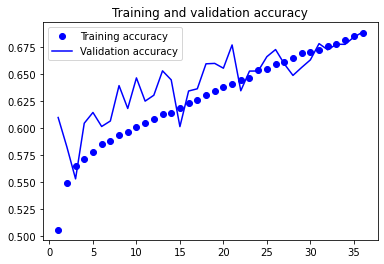

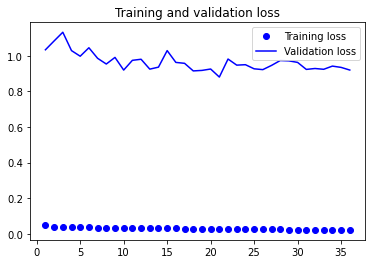

In [27]:
plot_history(history)

In [28]:
# train further

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=15),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                      factor=0.2, 
                                      patience=5, 
                                      verbose=1, 
                                      min_lr=1e-7),
]

model = history.model

history = model.fit(x=train_dataset, 
                    epochs=50, 
                    validation_data=val_dataset,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

Epoch 1/50
7192/7192 [==============================] - 609s 85ms/step - loss: 0.0222 - accuracy: 0.6893 - val_loss: 0.9321 - val_accuracy: 0.6807 - lr: 1.0000e-04
Epoch 2/50
7192/7192 [==============================] - 580s 81ms/step - loss: 0.0220 - accuracy: 0.6917 - val_loss: 0.9689 - val_accuracy: 0.6692 - lr: 1.0000e-04
Epoch 3/50
7192/7192 [==============================] - 594s 83ms/step - loss: 0.0216 - accuracy: 0.6941 - val_loss: 0.9427 - val_accuracy: 0.6803 - lr: 1.0000e-04
Epoch 4/50
7192/7192 [==============================] - 631s 88ms/step - loss: 0.0213 - accuracy: 0.6985 - val_loss: 0.9488 - val_accuracy: 0.6827 - lr: 1.0000e-04
Epoch 5/50
7192/7192 [==============================] - 601s 84ms/step - loss: 0.0210 - accuracy: 0.7018 - val_loss: 0.9442 - val_accuracy: 0.6886 - lr: 1.0000e-04
Epoch 6/50
7191/7192 [============================>.] - ETA: 0s - loss: 0.0208 - accuracy: 0.7028
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
7192/

KeyboardInterrupt: 

---

In [33]:
from tensorflow.keras import layers
from keras_vggface.vggface import VGGFace

# Define Data Augmentation Layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomBrightness(.2),
        layers.RandomContrast(.2),
        layers.RandomZoom(.3, fill_mode="constant"),
    ]
)

# Load Base Model
vgg_model = VGGFace(model="resnet50", include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = True
for layer in vgg_model.layers[:-33]: # starting with res5
    layer.trainable = False
    
# Add Head Model (Finetune)
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(x)
x = vgg_model(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(1024, activation="relu")(x)
outputs = layers.Dense(8, activation='softmax', name='classifier', dtype="float32")(x) # opt-out mixed precision for softmax layer
model = keras.Model(inputs, outputs)


#vgg_model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Load dataset
(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

from datetime import datetime
now = datetime.today()
current_time = now.strftime("%Y%m%d_%H-%M")
model_name = f"{current_time}_fer_finetuning_vggFace.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=15),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                      factor=0.2, 
                                      patience=5, 
                                      verbose=1, 
                                      min_lr=1e-7)
]

# fit model
print(f'Saving model as: {model_name}')
history = model.fit(x=train_dataset, 
                    epochs=50, 
                    validation_data=val_dataset,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

Found 287651 files belonging to 8 classes.
Using 230121 files for training.
Using 57530 files for validation.
Found 3999 files belonging to 8 classes.
Saving model as: 20230714_14-01_fer_finetuning_vggFace.keras
Epoch 1/50
7192/7192 [==============================] - 531s 73ms/step - loss: 0.0491 - accuracy: 0.4878 - val_loss: 0.9459 - val_accuracy: 0.6668 - lr: 0.0010
Epoch 2/50
7192/7192 [==============================] - 525s 73ms/step - loss: 0.0435 - accuracy: 0.5352 - val_loss: 1.0001 - val_accuracy: 0.6262 - lr: 0.0010
Epoch 3/50
7192/7192 [==============================] - 526s 73ms/step - loss: 0.0416 - accuracy: 0.5477 - val_loss: 0.9849 - val_accuracy: 0.6275 - lr: 0.0010
Epoch 4/50
7192/7192 [==============================] - 528s 73ms/step - loss: 0.0406 - accuracy: 0.5544 - val_loss: 1.3317 - val_accuracy: 0.5325 - lr: 0.0010
Epoch 5/50
7192/7192 [==============================] - 526s 73ms/step - loss: 0.0398 - accuracy: 0.5612 - val_loss: 1.1132 - val_accuracy: 0.6160 -

## #1 Best Model so far

In [37]:
model = history.model
print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

model.save('20230714_fer_finetuning_vggFace_resnet50_best')


Evaluating: 20230714_14-01_fer_finetuning_vggFace.keras
125/125 [==============================] - 5s 41ms/step - loss: 1.1813 - accuracy: 0.5829
Test accuracy: 0.583


INFO:tensorflow:Assets written to: 20230714_fer_finetuning_vggFace_resnet50_best/assets


INFO:tensorflow:Assets written to: 20230714_fer_finetuning_vggFace_resnet50_best/assets


In [41]:
model.get_compile_config()

{'optimizer': {'module': 'keras.optimizers',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'weight_decay': None,
   'clipnorm': None,
   'global_clipnorm': None,
   'clipvalue': None,
   'use_ema': False,
   'ema_momentum': 0.99,
   'ema_overwrite_frequency': None,
   'jit_compile': True,
   'is_legacy_optimizer': False,
   'learning_rate': 8.000000889296643e-06,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': 'sparse_categorical_crossentropy',
 'metrics': ['accuracy'],
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': None,
 'steps_per_execution': None,
 'jit_compile': None}

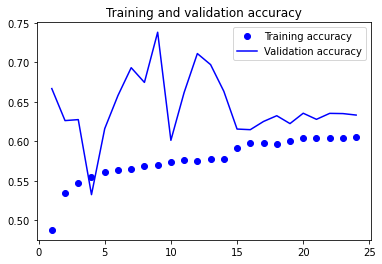

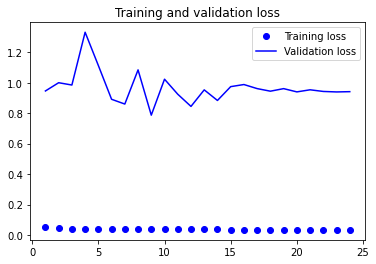

In [35]:
plot_history(history)

In [44]:
# continue training
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='20230714_fer_finetuning_vggFace_resnet50_best_continue',
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=15),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                      factor=0.2, 
                                      patience=5, 
                                      verbose=1, 
                                      min_lr=1e-7)
]
print(f'Saving model as: 20230714_fer_finetuning_vggFace_resnet50_best_continue')
history = model.fit(x=train_dataset, 
                    epochs=50, 
                    validation_data=val_dataset,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

Saving model as: 20230714_fer_finetuning_vggFace_resnet50_best_continue
Epoch 1/50
7191/7192 [============================>.] - ETA: 0s - loss: 0.0332 - accuracy: 0.6062

INFO:tensorflow:Assets written to: 20230714_fer_finetuning_vggFace_resnet50_best_continue/assets


INFO:tensorflow:Assets written to: 20230714_fer_finetuning_vggFace_resnet50_best_continue/assets


7192/7192 [==============================] - 601s 84ms/step - loss: 0.0332 - accuracy: 0.6062 - val_loss: 0.9442 - val_accuracy: 0.6323 - lr: 8.0000e-06
Epoch 2/50
7192/7192 [==============================] - 590s 82ms/step - loss: 0.0332 - accuracy: 0.6057 - val_loss: 0.9492 - val_accuracy: 0.6302 - lr: 8.0000e-06
Epoch 3/50
7192/7192 [==============================] - 583s 81ms/step - loss: 0.0331 - accuracy: 0.6048 - val_loss: 0.9452 - val_accuracy: 0.6309 - lr: 8.0000e-06
Epoch 4/50
7192/7192 [==============================] - 592s 82ms/step - loss: 0.0329 - accuracy: 0.6070 - val_loss: 0.9497 - val_accuracy: 0.6294 - lr: 8.0000e-06
Epoch 5/50
7191/7192 [============================>.] - ETA: 0s - loss: 0.0330 - accuracy: 0.6074

INFO:tensorflow:Assets written to: 20230714_fer_finetuning_vggFace_resnet50_best_continue/assets


INFO:tensorflow:Assets written to: 20230714_fer_finetuning_vggFace_resnet50_best_continue/assets


7192/7192 [==============================] - 597s 83ms/step - loss: 0.0330 - accuracy: 0.6074 - val_loss: 0.9439 - val_accuracy: 0.6332 - lr: 8.0000e-06
Epoch 6/50
7191/7192 [============================>.] - ETA: 0s - loss: 0.0330 - accuracy: 0.6065

INFO:tensorflow:Assets written to: 20230714_fer_finetuning_vggFace_resnet50_best_continue/assets


INFO:tensorflow:Assets written to: 20230714_fer_finetuning_vggFace_resnet50_best_continue/assets


7192/7192 [==============================] - 543s 76ms/step - loss: 0.0330 - accuracy: 0.6065 - val_loss: 0.9398 - val_accuracy: 0.6346 - lr: 8.0000e-06
Epoch 7/50
7192/7192 [==============================] - 526s 73ms/step - loss: 0.0331 - accuracy: 0.6063 - val_loss: 0.9406 - val_accuracy: 0.6339 - lr: 8.0000e-06
Epoch 8/50
7192/7192 [==============================] - 526s 73ms/step - loss: 0.0330 - accuracy: 0.6061 - val_loss: 0.9440 - val_accuracy: 0.6332 - lr: 8.0000e-06
Epoch 9/50
7192/7192 [==============================] - 525s 73ms/step - loss: 0.0330 - accuracy: 0.6065 - val_loss: 0.9473 - val_accuracy: 0.6313 - lr: 8.0000e-06
Epoch 10/50
7191/7192 [============================>.] - ETA: 0s - loss: 0.0330 - accuracy: 0.6073

INFO:tensorflow:Assets written to: 20230714_fer_finetuning_vggFace_resnet50_best_continue/assets


INFO:tensorflow:Assets written to: 20230714_fer_finetuning_vggFace_resnet50_best_continue/assets


7192/7192 [==============================] - 537s 75ms/step - loss: 0.0330 - accuracy: 0.6073 - val_loss: 0.9392 - val_accuracy: 0.6357 - lr: 8.0000e-06
Epoch 11/50
7192/7192 [==============================] - 525s 73ms/step - loss: 0.0331 - accuracy: 0.6066 - val_loss: 0.9396 - val_accuracy: 0.6357 - lr: 8.0000e-06
Epoch 12/50
7192/7192 [==============================] - 525s 73ms/step - loss: 0.0330 - accuracy: 0.6060 - val_loss: 0.9449 - val_accuracy: 0.6330 - lr: 8.0000e-06
Epoch 13/50
7192/7192 [==============================] - 525s 73ms/step - loss: 0.0330 - accuracy: 0.6053 - val_loss: 0.9395 - val_accuracy: 0.6356 - lr: 8.0000e-06
Epoch 14/50
7191/7192 [============================>.] - ETA: 0s - loss: 0.0331 - accuracy: 0.6067

INFO:tensorflow:Assets written to: 20230714_fer_finetuning_vggFace_resnet50_best_continue/assets


INFO:tensorflow:Assets written to: 20230714_fer_finetuning_vggFace_resnet50_best_continue/assets


7192/7192 [==============================] - 535s 74ms/step - loss: 0.0331 - accuracy: 0.6067 - val_loss: 0.9381 - val_accuracy: 0.6362 - lr: 8.0000e-06
Epoch 15/50
7192/7192 [==============================] - 526s 73ms/step - loss: 0.0329 - accuracy: 0.6062 - val_loss: 0.9395 - val_accuracy: 0.6359 - lr: 8.0000e-06
Epoch 16/50
7191/7192 [============================>.] - ETA: 0s - loss: 0.0328 - accuracy: 0.6066

INFO:tensorflow:Assets written to: 20230714_fer_finetuning_vggFace_resnet50_best_continue/assets


INFO:tensorflow:Assets written to: 20230714_fer_finetuning_vggFace_resnet50_best_continue/assets


7192/7192 [==============================] - 536s 75ms/step - loss: 0.0328 - accuracy: 0.6066 - val_loss: 0.9308 - val_accuracy: 0.6403 - lr: 8.0000e-06
Epoch 17/50
7192/7192 [==============================] - 526s 73ms/step - loss: 0.0329 - accuracy: 0.6081 - val_loss: 0.9385 - val_accuracy: 0.6358 - lr: 8.0000e-06
Epoch 18/50
 201/7192 [..............................] - ETA: 7:55 - loss: 0.0340 - accuracy: 0.5978

KeyboardInterrupt: 

In [49]:
model = keras.models.load_model('20230714_fer_finetuning_vggFace_resnet50_best_continue')
print(f"Evaluating: 20230714_fer_finetuning_vggFace_resnet50_best_continue")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230714_fer_finetuning_vggFace_resnet50_best_continue
125/125 [==============================] - 6s 42ms/step - loss: 1.1889 - accuracy: 0.5846
Test accuracy: 0.585


In [52]:
model.save('20230714_fer_finetuning_vggFace_resnet50_best_continue')

INFO:tensorflow:Assets written to: 20230714_fer_finetuning_vggFace_resnet50_best_continue/assets


INFO:tensorflow:Assets written to: 20230714_fer_finetuning_vggFace_resnet50_best_continue/assets


---

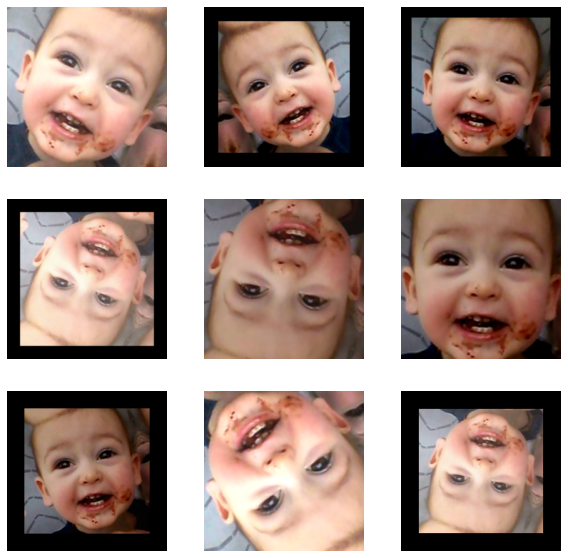

In [32]:
# Check Data Augmentation Layers
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomBrightness(.2),
        layers.RandomContrast(.2),
        layers.RandomZoom(.3, fill_mode="constant"),
    ]
)

#(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

fig = plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")